In [1]:
import numpy as np
import pickle
import sklearn
from sklearn.model_selection import train_test_split

In [3]:
# Load Closed World dataset

USE_SUBLABEL = False
URL_PER_SITE = 10
TOTAL_URLS   = 950

# Load the pickle file
print("Loading datafile...")
with open('db/mon_standard.pkl', 'rb') as fi: # mon_standard.pkl in directory
    data = pickle.load(fi)

X1_closed = [] # Array to store instances (timestamps) - 19,000 instances
X2_closed = [] # Array to store instances (direction*size) - size information
y_closed = [] # Array to store the site of each instance - 19,000 instances

# Differentiate instances and sites, and store them in the respective x and y arrays
# x array (direction*timestamp), y array (site label)
for i in range(TOTAL_URLS):
    if USE_SUBLABEL:
        label = i
    else:
        label = i // URL_PER_SITE
    for sample in data[i]:
        size_seq = []
        time_seq = []
        for c in sample:
            dr = 1 if c > 0 else -1
            time_seq.append(abs(c))
            size_seq.append(dr * 512)
        X1_closed.append(time_seq)
        X2_closed.append(size_seq)
        y_closed.append(label)

print(f'Total closed world dataset samples: {len(y_closed)}')

# Features of new .pkl file
output_data = {
    'X1_closed': X1_closed,
    'X2_closed': X2_closed,
    'y_closed': y_closed
}

# Save 'mon_standard_withlabel_binary.pkl' as File
output_file = 'db/mon_standard_withlabel.pkl'

with open(output_file, 'wb') as f:
    pickle.dump(output_data, f)


Loading datafile...
Total closed world dataset samples: 19000


In [4]:
# Load Open World dataset
TOTAL_URLS = 3000  # total number in the dataset

# Load 3,000 unmon pickle file
print("Loading datafile...")
with open('db/unmon_standard10_3000.pkl', 'rb') as f:  # unmon_standard10_3000.pkl in directory
    x = pickle.load(f)

X1_open = [] # Array to store instances (timestamps) - 10,000 instances, e.g., [[0.0, 0.5, 3.4, ...], [0.0, 4.5, ...], [0.0, 1.5, ...], ... [... ,45.8]]
X2_open = [] # Array to store instances (direction*size) - size information
y_open = [] # **Added** Array to store the unmonitored site as -1

for i in range(TOTAL_URLS):
    size_seq = []
    time_seq = []
    for c in x[i]:
        dr = 1 if c > 0 else -1
        time_seq.append(abs(c))
        size_seq.append(dr * 512) # In the pickle file, there is no size information, so the conversion code is set to multiply by 512 uniformly.
    X1_open.append(time_seq)
    X2_open.append(size_seq)
    y_open.append(-1)


print(f'Total open world dataset samples: {len(y_open)}')

output_data = {
    'X1_open': X1_open,
    'X2_open': X2_open,
    'y_open': y_open
}

# Save as 'unmon_standard10_3000_withlabel.pkl'
output_file = 'db/unmon_standard10_3000_withlabel.pkl'

with open(output_file, 'wb') as f:
    pickle.dump(output_data, f)

Loading datafile...
Total open world dataset samples: 3000


In [5]:
# Load Files
with open('db/mon_standard_withlabel.pkl', 'rb') as f:
    monitored_data = pickle.load(f)

with open('db/unmon_standard10_3000_withlabel.pkl', 'rb') as f:
    unmonitored_data = pickle.load(f)

# Monitored data
monitored_X1 = monitored_data['X1_closed']
monitored_X2 = monitored_data['X2_closed']
monitored_y = monitored_data['y_closed']  # label : '0-94'

# Unmonitored data
unmonitored_X1 = unmonitored_data['X1_open']
unmonitored_X2 = unmonitored_data['X2_open']
unmonitored_y = unmonitored_data['y_open']  # label : '-1'

# Integrate dataset
X1 = monitored_X1 + unmonitored_X1
X2 = monitored_X2 + unmonitored_X2
y = monitored_y + unmonitored_y

combined_data = {
    'X1': X1,
    'X2': X2,
    'y': y
}

# Save 'combined_dataset_binary.pkl' as Fil
output_file = 'db/combined_dataset.pkl'

with open(output_file, 'wb') as f:
    pickle.dump(combined_data, f)

In [6]:
# Load combined dataset
with open('db/combined_dataset_binary.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

# Feature extraction
pkt_timestamps = X1
pkt_sizes = X2

# Extract cumulative packet sizes
cumulative_pkt_sizes = [np.cumsum(packet_sizes).tolist() for packet_sizes in pkt_sizes]
X3 = cumulative_pkt_sizes

# Extract bursts
bursts = []
for instance in pkt_sizes:
    instance_bursts = []
    current_burst = 0
    current_direction = np.sign(instance[0])  # Initialize with the first packet's direction
    for size in instance:
        direction = np.sign(size)
        if direction == current_direction:
            # Accumulate burst size for the same direction
            current_burst += size
        else:
            # Append the completed burst and reset for the new direction
            instance_bursts.append(current_burst)
            current_burst = size
            current_direction = direction
    instance_bursts.append(current_burst)  # Add the last burst
    bursts.append(instance_bursts)
X4 = bursts

# Extract time differences (packet inter-arrival times)
time_differences = []
for timestamps in pkt_timestamps:
    time_diff = np.diff(timestamps).tolist()  # Calculate differences between consecutive timestamps
    time_differences.append(time_diff)
X5 = time_differences

# Extract standard deviation of packet sizes
standard_deviation = [np.std(packet_sizes) for packet_sizes in pkt_sizes]
X6 = standard_deviation

print("X5 (Packet Time Differences):", X5[:2])
print("X6 (Packet Size Standard Deviation):", X6[:2])


X5 (Packet Time Differences): [[0.14, 0.0, 0.16999999999999998, 0.0, 0.2, 0.0, 0.0, 0.24, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.13, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010000000000000009, 0.23999999999999988, 0.0, 0.17000000000000015, 0.0, 0.0, 0.0, 0.0, 0.16999999999999993, 0.0, 0.1100000000000001, 0.1399999999999999, 0.0, 0.0, 0.25, 0.24, 0.0, 0.0, 0.16999999999999993, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0900000000000003, 0.0, 0.009999999999999787, 0.20000000000000018, 0.0, 0.0, 0.2999999999999998, 0.0, 0.06999999999999984, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03000000000000025, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06999999999999984, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020000000000000018, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020000000000000018, 0.29000000000000

In [7]:
print(f'Total samples: {len(y)}') # monitored 19,000 + unmonitored 3,000

Total samples: 22000


In [8]:
# Combine all features into one list of feature vectors
X_combined = []

for i in range(len(X1)):
    instance_features = {
        'timestamps': X1[i],
        'packet_sizes': X2[i],
        'cumulative_pkt_sizes': X3[i],
        'bursts': X4[i],
        'time_differences': X5[i],  # Add time differences feature
        'size_std_dev': X6[i]  # Add size standard deviation feature
    }
    X_combined.append(instance_features)

# Flatten each feature vector for each instance in X_combined
X_flattened = []

for instance in X_combined:
    feature_vector = (
        instance['timestamps'] +
        instance['packet_sizes'] +
        instance['cumulative_pkt_sizes'] +
        instance['bursts'] +
        instance['time_differences'] +  # Add time differences feature
        [instance['size_std_dev']]  # Size standard deviation is a single value per instance, added as a list
    )
    X_flattened.append(feature_vector)

# Perform train_test_split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_flattened, y, test_size=0.2, random_state=42)


In [9]:
# Pad sequences with -1 using numpy to ensure all feature vectors are the same length
max_length = 1000  # Define maximum length to which sequences will be padded

# Pad each feature vector to the maximum length with -1
X_train_padded = np.array([
    np.pad(fv, (0, max(0, max_length - len(fv))), mode='constant', constant_values=-1)[:max_length]
    for fv in X_train
])

# Pad each feature vector to the maximum length with -1
X_test_padded = np.array([
    np.pad(fv, (0, max(0, max_length - len(fv))), mode='constant', constant_values=-1)[:max_length]
    for fv in X_test
])

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_padded = scaler.fit_transform(X_train_padded)
X_test_padded = scaler.transform(X_test_padded)

In [11]:
# Multi-class Classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Define the RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=1000, max_depth=None, random_state=42, n_jobs=-1) # n_estimators = 1000

# Train the Model
rf_clf.fit(X_train_padded, y_train)

# Predict with Testset
y_pred_rf = rf_clf.predict(X_test_padded)

# Evaluate Accuracy
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print(f"랜덤 포레스트 정확도: {rf_accuracy:.4f}")

랜덤 포레스트 정확도: 0.4270


In [12]:
# Classification Report
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

# Print Precision, Recall, F1-Score (Weighted average)
precision = precision_score(y_test, y_pred_rf, average='weighted')
recall = recall_score(y_test, y_pred_rf, average='weighted')
f1 = f1_score(y_test, y_pred_rf, average='weighted')

print(f"\nPrecision (Weighted): {precision:.4f}")
print(f"Recall (Weighted): {recall:.4f}")
print(f"F1-Score (Weighted): {f1:.4f}")


Classification Report:
              precision    recall  f1-score   support

          -1       0.58      0.90      0.70       590
           0       0.24      0.17      0.20        30
           1       0.28      0.16      0.20        44
           2       0.19      0.15      0.16        41
           3       0.25      0.15      0.19        33
           4       0.43      0.62      0.51        32
           5       0.19      0.08      0.11        37
           6       0.25      0.16      0.19        38
           7       0.33      0.17      0.23        35
           8       0.42      0.24      0.31        33
           9       0.30      0.27      0.29        26
          10       0.48      0.26      0.33        43
          11       0.27      0.18      0.21        45
          12       0.61      0.50      0.55        44
          13       0.17      0.09      0.12        46
          14       0.43      0.57      0.49        37
          15       0.45      0.23      0.31        39
   

In [13]:
rf_clf = RandomForestClassifier(n_estimators=300, max_depth=10, random_state=42, n_jobs=-1)
rf_clf.fit(X_train_padded, y_train)

RandomForestClassifier(max_depth=10, n_estimators=300, n_jobs=-1,
                       random_state=42)

In [ ]:
'''
# 하이퍼파라미터 그리드 (세분화)
param_grid = {
    'n_estimators': [100, 300, 500],  # 트리 개수 세분화
    'max_depth': [None, 10, 20],  # 트리 깊이 범위 축소
    'min_samples_split': [2, 5],  # 최소 샘플 수
    'min_samples_leaf': [1, 2],  # 리프 노드의 최소 샘플 수
    'max_features': ['sqrt', 'log2'],  # 피처 샘플링 방식
    'bootstrap': [True, False],  # 부트스트랩 여부
    'criterion': ['gini', 'entropy']  # 불순도 측정 방법 (지니 불순도, 엔트로피)
}

# 그리드 서치 (3겹 교차 검증)
grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# 학습
grid_search.fit(X_train_padded, y_train)

# 최적의 파라미터와 성능
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Score: {grid_search.best_score_:.4f}")
'''

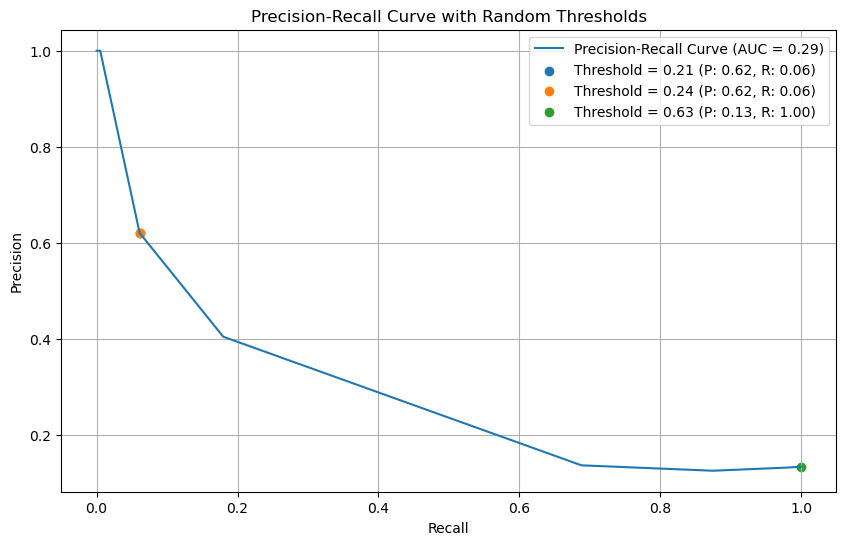

In [16]:
# Precision-recall curve with random thresholds
from sklearn.metrics import precision_recall_curve, auc
import numpy as np
import matplotlib.pyplot as plt

# Probability predictions from Random Forest
y_prob = np.mean(rf_clf.predict_proba(X_test_padded), axis=1)

# Compute Precision-Recall Curve for the entire dataset
precision, recall, thresholds = precision_recall_curve(y_test, y_prob, pos_label=-1)  # Use `-1` for unmonitored label or adjust as needed
pr_auc = auc(recall, precision)

# Plot the Precision-Recall Curve
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, label=f'Precision-Recall Curve (AUC = {pr_auc:.2f})')

# Randomly select 3 threshold values between 0 and 1
random_thresholds = np.random.uniform(0, 1, size=3)
random_thresholds.sort()

# Mark the selected random thresholds on the graph
for thr in random_thresholds:
    idx = np.argmin(np.abs(thresholds - thr))    
    # Clip index to make sure it's within bounds (since recall might be longer by one element)
    idx = min(idx, len(recall) - 1)
    plt.scatter(recall[idx], precision[idx], label=f'Threshold = {thr:.2f} (P: {precision[idx]:.2f}, R: {recall[idx]:.2f})')

plt.title("Precision-Recall Curve with Random Thresholds")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc='best')
plt.grid()
plt.show()

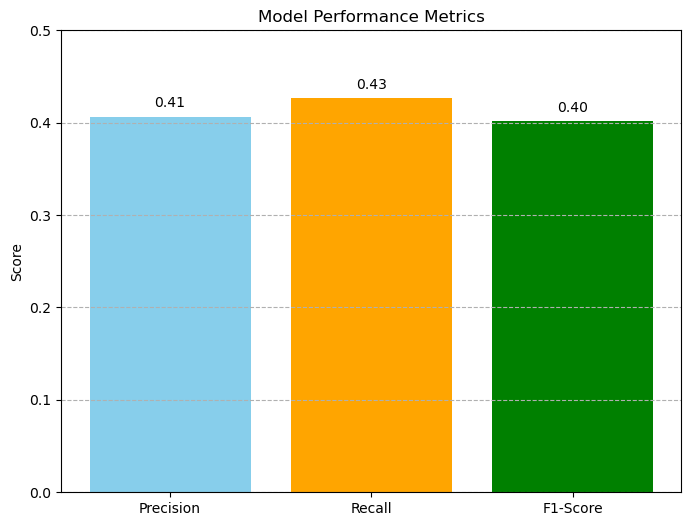

In [17]:
# Performance metrics plot - Precision, Recall, F1-Score
metrics = ['Precision', 'Recall', 'F1-Score']
values = [0.4066, 0.4270, 0.4014]

# Create a bar chart
plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color=['skyblue', 'orange', 'green'])

# Annotate the bars with their values
for i, v in enumerate(values):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center')

plt.title("Model Performance Metrics")
plt.ylabel("Score")
plt.ylim(0.0, 0.5)  # Adjusted range to accommodate lower scores
plt.grid(axis='y', linestyle='--')
plt.show()

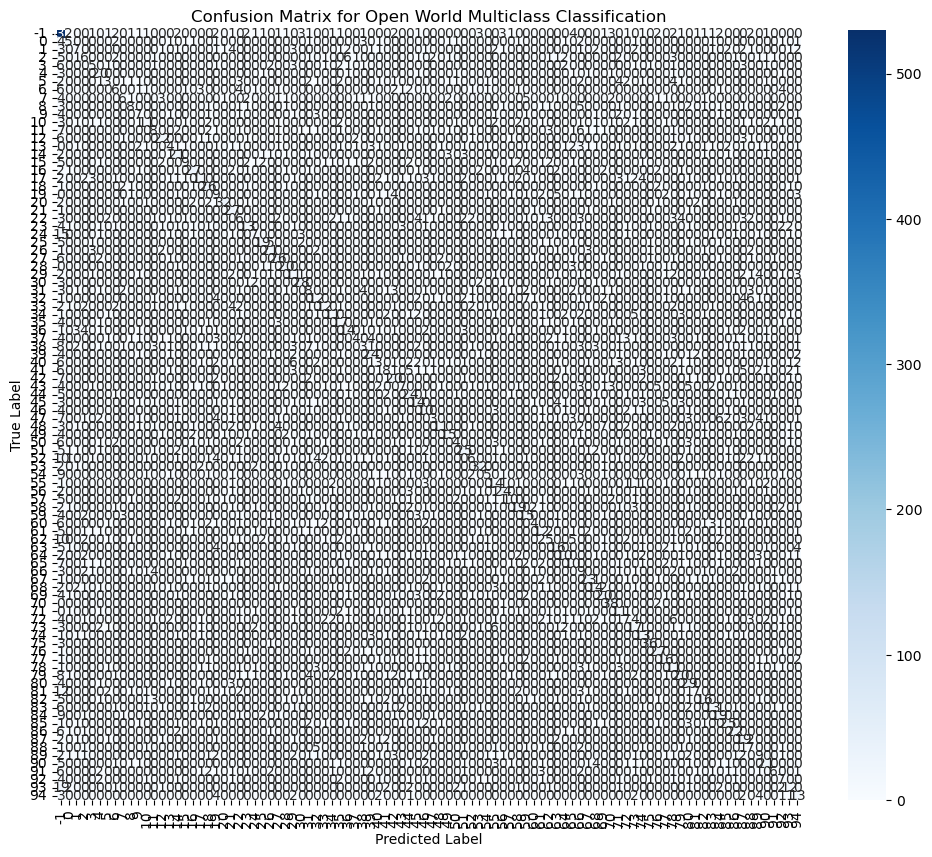

In [18]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_rf)

# Visualize Confusion Matrix
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title("Confusion Matrix for Open World Multiclass Classification")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()